## 10.2 Implementing Backpropagation

In this exercise we will implement a simple multi-layer perceptron for the classic dataset of housing price prediction in Boston. We begin with loading and splitting the data, as well as normalizing the features. This is an important preprocessing step and should almost always be done!

By transforming each feature to $f' = \frac{f - \mu_f}{\sigma_f}$, we make sure that they are centered around zero and in comparable ranges.

**Q 10.2.1: What would a standard deviation of zero mean for a feature?**



In [1]:
%matplotlib inline
import numpy as np    
import matplotlib.pyplot as plt
import seaborn

# Load the dataset
from sklearn.datasets import load_boston
boston = load_boston()

# Split the dataset in training and validation set
n_training_samples = 300
X_train = boston.data[:n_training_samples]
y_train = boston.target[:n_training_samples].reshape((-1, 1))
X_valid = boston.data[n_training_samples:]
y_valid = boston.target[n_training_samples:].reshape((-1, 1))

# Normalize the features by centering them around the mean 
# dividing by the standard deviation. Note that we calculate
# the statistical moments only on the training set!
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)    # std deviation around axis: whitening, same variance in all features

X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std

After loading the data, we can set up the network. We will stick to the architecture from the lecture: one hidden layer with a rectified linear activation and the output layer with linear output since this is a regression task. After setting this up, we need to be able to correctly pass data forward and backward through the network. Below the code stub here, you will find a gradient checking procedure to verify your implementation before we turn to the optimization in the next part.

**Task a) Setting up an MLP:** 
  * Implement the missing pieces of the architecture for one hidden layer with 50 units and rectified linear activation and one linear output unit
  * Implement the forward and backward pass in batch form for this architecture.
  * Verify your implementation with the provided gradient checking procedure.

In [6]:
# Define the network architecture
n_input_units = X_train.shape[1]   # number of features D --> 13
print("X_train.shape ", X_train.shape)
print("n_input_units: ", n_input_units)
n_hidden_units = 50
n_output_units = 1

# Implement the shapes in terms of the above definitions
# For verification and broadcasting reasons the bias 
# should have 1 row, i.e. the shape should be (1, x)
# with x determined by you.

# Every layer is a matrix multiplication plus a bias, so
# the shapes must match those operations.
hidden_weights_shape = (n_input_units, n_hidden_units) # w0 (13,50) Matrix 13 (features x) x 50 (hidden nodes)
output_weights_shape = (n_hidden_units, n_output_units) # w1 (50,1) one weight from each node 
hidden_bias_shape = (1, n_hidden_units) # b0 (1,50) --> (30,50) one bias parameter in Each hidden node (corresponding with x0 in Bishop page 228)
output_bias_shape = (1, n_output_units) # b1 (1,1) --> (30,1) one bias parameter, because only one output parameter
# number of samples 30 (in comments, and for test)

print("hidden_weights_shape",hidden_weights_shape)
print("output_bias_shape",output_bias_shape)


# For the optimization with gradient descent, we have to pick an
# initial guess for the solution.
def init_weights():
    # We initialize the weights with a Gaussian distribution
    hidden_weights = np.random.standard_normal(hidden_weights_shape) * 0.1
    output_weights = np.random.standard_normal(output_weights_shape) * 0.1

    # The bias is usually initialized to zero
    hidden_bias = np.zeros(hidden_bias_shape)
    output_bias = np.zeros(output_bias_shape)

    return hidden_weights, output_weights, hidden_bias, output_bias
    
hidden_weights, output_weights, hidden_bias, output_bias = init_weights()
    
# Activation functions
def relu(x):   #activation function for hidden layer
    # It's important to use the elementwise max function in numpy
    return np.maximum(0., x)

def linear(x):   #activation function for output
    return x

# The forward pass for this neural network
# The output for every layer should be computed in
# two steps: before and after applying the activation
# function.
def forward_pass(X):
    #calculate activation function for all 50 units, based on 

    #print("X",X.shape) 
    #print("hidden_weights",hidden_weights.shape) 
    hidden_linear = np.dot(X,hidden_weights)   # a_0 = wTx + b0 --> shape 30 x 50 --> different 
    #print("hidden_linear",hidden_linear.shape)    

    #print("n_input_units ",n_input_units)

    # expand bias = 1x50 vector to 30x50 matrix, with 30 identical rows, for convenient Matrix Add a_0 = X x M + B
    # 30 is for test data, real training data always 300 instead of 30
#    hidden_bias_expanded = np.repeat(np.atleast_2d(hidden_bias),X.shape[0],axis=0)
#    print("hiddenbias ", hidden_bias)
#    for i in range(X.shape[0]-1): 
#        hidden_bias_expanded = np.append(hidden_bias_expanded,hidden_bias,axis=0)

    hidden_linear = hidden_linear + hidden_bias    # a_0 = wTx + b0  dimenions added automatically by "broadcasting"
    
    hidden_act = relu(hidden_linear) # Activator Function, dim(30,50) : z_0 = h(a_0) with acivator function h(x) ReLu 
    #hidden_act = linear(hidden_linear) # Activator Function, dim(30,50) : z_0 = h(a_0) with acivator function h(x) ReLu 
  
    output_linear = np.dot(hidden_act,output_weights) + output_bias   # (30,1) a1 = z_0 * w_1 + b_1
    #print("output_linear ",output_linear.shape)
    
    output_act = linear(output_linear)   # Y=h(a1) , final output / prediction : (30,1) 
    
    # We collect the activations in a dictionary here,
    # because we need them for the backward pass
    activations = {
        'hidden_linear': hidden_linear,    #a0 (30,50)
        'hidden_act': hidden_act,          #z0 (30,50)
        'output_linear': output_linear,    #a1 (30,1)
        'output_act': output_act           #y  (30,1) 
    }
    
    # The prediction is in output_act
    return output_act, activations


# Loss function
# Implement the mean square error function 
def squared_error(y_predicted, y):
    #print("y.shape ", y.shape)
    err = 0
    for i in range(y.shape[0]):
        err += (y_predicted[i]-y[i])*(y_predicted[i]-y[i])
    err=err/(2*y.shape[0])
    return err # return scalar 

# 
#X_test = np.random.standard_normal((30, n_input_units))
#y_test = np.random.standard_normal((30, n_output_units))
#loss_plus = squared_error(forward_pass(X_test)[0], y_test)
#print ("loss_plus ", loss_plus)

# This completes everything we need for the forward pass
# If you are unsure about your implementation, feel
# free to pass random values through and check the output
# shapes

# For the backward pass, we will need the
# derivatives of the activation functions and the loss function
# The gradients are defined in the slides, we just need to match
# the input shapes.

# relu grad for one dim / scalar
def relu_grad_1d(x):
    if x>0:
        return 1
    else:
        return 0

# my take, element-wise
def a_relu_grad(x):
    grad=np.zeros(x.shape)     #correct / necessary to create a new matrix at each call of the function? 
    for i in range(x.shape[0]):
        for k in range(x.shape[1]):
            grad[i,k] = relu_grad_1d(x[i,k])
    return grad    #return matrix of equal shape than argument

# return new matrix with 1 / 0, if value in argument matrix is >0 / <0 
# python style: 
def relu_grad(x):
    dx = np.zeros_like(x)  # initialise matrix
    dx[x > 0] = 1.         # python stylish elementwise boolean indexing
    #print("relu_grad {}".format(dx))
    return dx    
    
    #return np.maximum(0., x)

def linear_grad(x):
    # my false version: return x
    return np.ones_like(x)

def tanh_grad(x):
    dx = np.zeros_like(x)  # initialise matrix
    dx = 1 - (np.tanh(x))**2  # tanh and sqr elementwise, "1 -" is broadcasted
    return dx    

# The error gradient wrt the predicted y value
def squared_error_grad(y_hat, y):
    n_samples = float(y.shape[0])
    return (y_hat - y)/n_samples   # (works with matrices elementwise )
    

# The backward pass is responsible for calculating the derivatives
# of the loss with respect to the weights and biases of each layer.
# It also helps to think about the shapes (again!)
def  backward_pass(X, y, activations):
    # For most of the gradients you already filled out helper functions. Use them!
    
    # Wherever you need the elements of the forward pass, you will find them
    # in the activations dictionary. See the forward pass for the keys or
    # print it to find out.
    
    # The first thing to calculate is the gradient of the error function wrt
    # the prediction the network made
    error_grad = squared_error_grad(activations['output_act'], y)   #dL/dY_hat   dim (30,1), as y
    
    # Now we can go backwards layer by layer
    # First derive wrt the activation function, because it is the last thing we did in
    # the forward pass 
    #output_act_grad = linear_grad(squared_error_grad(activations['output_act'],y))
    # my false version: output_act_grad = linear_grad(error_grad)  
    # dL/da1    dim (30,1), as error_grad - after Bishop dL/da1 is "error sigma"
    output_act_grad = error_grad * linear_grad(activations['output_linear']) 
    
    
    # Two objects contributed to Xw + b: the weights and the bias
    # These are the parameters of our network and will let us update
    # the network later.
    # dL/dw1 = z0T * dL/da1  dim (50,1), as
    output_weights_grad = np.dot(np.transpose(activations['hidden_act']),output_act_grad)  
    
    # Remember that the bias was broadcasted from its shape (1, k) to 
    # (n, k) with n being the number of samples. For the correct gradient
    # you need to get back to (1, k) by summing up.  (being k=1 in this case, only one output variable)
    # output_bias_grad = output_act_grad # dL/db1 = 1(nxn) * dL/da1 = dL/da1
    output_bias_grad = np.atleast_2d(np.sum(output_act_grad)) # dL/db1 = 1(nxn) * dL/da1 = dL/da1
    # output_bias_grad = output_act_grad.sum(axis=0, keepdims=True)
    
    # The last thing to do for the output layer is to take the derivative wrt
    # its input, so we can backpropagate the errors the previous layers need
    # to fix. dL/da1 = "error sigma" according to Bishop
    # dL/dz0 = dL/da1 * w1_T, dim (30,50) the output of the hidden layer = input to the output layer
    # dL/dz0 dim = (30,1)dot(1,50)  = (30,50)
    output_inp_grad = np.dot(output_act_grad,np.transpose(output_weights)) 

    # From here on, everything is the same as for the output layer, except
    # for the changed activation function
    #print("output_inp_grad \n", output_inp_grad)
    #hidden_act_grad = relu_grad(output_inp_grad)     # dL/da0 = dL/dz0*dz0/da0 dim(30,50)
    
    # return matrix with elementwise value of either dL/dz0 or zero, depending on if a0 > or < zero
    # hidden_act_grad = output_inp_grad * relu_grad(activations['hidden_linear']) --> * acts a hadamard product
    hidden_act_grad = np.multiply(output_inp_grad,relu_grad(activations['hidden_linear']))
    
    Test_act_grad = np.multiply(output_inp_grad,tanh_grad(activations['hidden_linear']))
    #hidden_act_grad = linear_grad(output_inp_grad)     # dL/da0 = dL/dz0*dz0/da0 dim(30,50)
    #print("hidden_act_grad \n", hidden_act_grad)
    
    hidden_weights_grad = np.dot(np.transpose(X),hidden_act_grad) # dL/dw0 = XT * dL/da0  dim(13,30)x(30,50)=(13,50)
    
    # collapse from (30,50) --> (1,50)
    hidden_bias_grad = np.atleast_2d(np.sum(hidden_act_grad,axis=0)) # dL/db0 = dL/da0 (30,50) --> (1,50) to be condensed
    
    # These are the gradients we care about in the end, because
    # we need them to update our network
    gradients = (
        output_weights_grad,
        output_bias_grad,
        hidden_weights_grad,
        hidden_bias_grad
    )
    
    return gradients

X_train.shape  (300, 13)
n_input_units:  13
hidden_weights_shape (13, 50)
output_bias_shape (1, 1)


** Q 10.2.2: Remember how the regularization for polynomial models worked. How could you apply it here?**

#### Gradient Checking

Although everything is in place to turn our attention to training networks, it is always a good idea to verify the gradients of your network. Although there are nowadays lots of frameworks to compute the gradients for you, we use a (central) finite difference approximation to make sure the implementation is correct:

\begin{equation}
\frac{ \mathcal{L}(\theta + \epsilon, X) - \mathcal{L}(\theta - \epsilon, X)}{2 \epsilon} \approx \frac{\partial \mathcal{L}(\theta, X)}{\partial \theta}
\end{equation}

Looks familiar? For vanishing $\epsilon$ the left term is the definition of a derivative. With a small enough $\epsilon$ we can check the backward pass. If the code below does not print anything, you're golden!

Note though, that this method isn't perfect and the finite precision of floating point numbers sometimes interferes even with correct code. If you think this happens in your case, try changing the threshold and the epsilon, but in almost every case the current settings should work fine.

We are almost able to actually train our network. There is just one last thing missing:

**Task b) Updating the weights: ** Complete the training loop and implement the Gradient Descent updates using the gradients from the previous task.

It is also highly suggested that you play around with the number of hidden units, weight initialization, epochs and learning rate.

In [7]:
def check_gradients():
        X_test = np.random.standard_normal((30, n_input_units))   # (30,13)
        y_test = np.random.standard_normal((30, n_output_units))  # (30,1)
        #print("y_test_shape ", y_test.shape)
        #print("y_test ", y_test)
    
        y_pred, act = forward_pass(X_test)
        owg, obg, hwg, hbg = backward_pass(X_test, y_test, act)   #owg = output_weights_grad etc.
        # one forward + one backward pass, gradients are all determined and remain fix during check_param
        # weights an biases are initialised in the beginning and not modified here
        
        # checkparam: change output- and hidden weight and bias (referenced by argumentt "param" 
        # slightly, and compare differential with derivative
        
        def check_param(param, grad_est, epsilon=1e-7, error_threshold=1e-3):
            if np.any(np.isnan(param)):
                print('Parameters not implemented (NaN).')
                return False
            
            orig = param.copy()                 # initially store all params for restore after modifications
            for i in range(param.shape[0]):     # go through all rows and colums of this weight matrix
                for j in range(param.shape[1]): 
                    #if np.any(np.isnan(grad_est)):
                    #    print('NaNs detected')
                    #    return False
                    
                    #compares gradients of loss function wrt w_0, w_1, b_0, b_1 in all dimensions to small variations
                    # first: reset param to original values, before introducing small deviation eps
                    param[:] = orig.copy()  #e.g. output_weights matrix
                    # elementwise add small epsilon (would probably have worked via broadcasting with param = orig + epsilon)
                    param[i, j] = orig[i, j] + epsilon   #param is reference, hence here the actual weights are changed
                    #make forward pass with slightly changed weights, calculate difference in loss function
                    loss_plus = squared_error(forward_pass(X_test)[0], y_test)
                    
                    param[i, j] = orig[i, j] - epsilon
                    loss_minus = squared_error(forward_pass(X_test)[0], y_test)
                    # g = dL/dWij + one element of the dL/dW matrix
                    g = (loss_plus - loss_minus) / (2 * epsilon)   # dfferential --> approximated gradient, matrix
                    
                    if np.abs(g - grad_est[i, j]) > error_threshold:
                        print("Finite difference false: {}, iteration {},{}".format(g,i,j))
                        #print("loss_plus {}, loss_minus {}".format(loss_plus, loss_minus))
                        print('Yours: ', grad_est[i, j])
                        #return False
                    #else: 
                        #print("Finite difference correct: {}, iteration ({},{})".format(g,i,j))
                        #print('Yours: ', grad_est[i, j])
            return True

        print("Output weight gradient {}".format(check_param(output_weights, owg)))        
        
        print("Output bias gradient {}".format(check_param(output_bias, obg)))
        
        print("Hidden weight gradient {}".format(check_param(hidden_weights, hwg)))
        
        print("Hidden bias gradient {}".format(check_param(hidden_bias, hbg)))

check_gradients()

Output weight gradient True
Output bias gradient True
Hidden weight gradient True
Hidden bias gradient True


Epoch 0
	Training loss: 366.0
	Validation loss: 211.8
owg (50, 1),obg (1, 1),hwg (13, 50),hbg (1, 50)
Epoch 50
	Training loss: 271.1
	Validation loss: 129.4
Epoch 100
	Training loss: 64.8
	Validation loss: 52.0
Epoch 150
	Training loss: 15.4
	Validation loss: 174.8
Epoch 200
	Training loss: 9.4
	Validation loss: 243.6
Epoch 250
	Training loss: 7.6
	Validation loss: 238.8
Epoch 300
	Training loss: 6.5
	Validation loss: 237.9
Epoch 350
	Training loss: 5.7
	Validation loss: 256.1
Epoch 400
	Training loss: 5.1
	Validation loss: 278.8
Epoch 450
	Training loss: 4.7
	Validation loss: 305.5


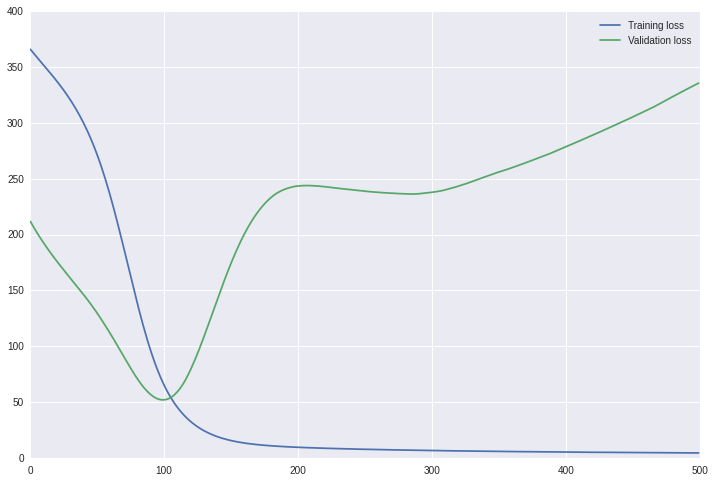

In [22]:
# Hyperparameters
n_epochs = 500
learning_rate = 0.001

n_hidden_units = 1
n_output_units = 1

# We keep track of training and validation error
# for every episode.
training_loss = np.ones(n_epochs) * np.nan   #initialise with nan
valid_loss = np.ones(n_epochs) * np.nan

hidden_weights, output_weights, hidden_bias, output_bias = init_weights()

# The training loop
for i in range(n_epochs):
    # Use your previously implemented methods to
    # Calculate the gradient for X_train

    # forward pass getting y_hat predictions and activations based on current weights
    y_hat_train, act_train = forward_pass(X_train)
    # backward pass using training data and activations from forward pass and yield all weight-gradients
    owg, obg, hwg, hbg = backward_pass(X_train, y_train, act_train)   #owg = output_weights_grad etc.
    
    if i == 5:
        print("owg {},obg {},hwg {},hbg {}".format(owg.shape,obg.shape,hwg.shape,hbg.shape))
        # print('owg {}'.format(owg.shape))   
    # now doing forward pass on validation dataset (only to check / display error while running through training epochs)
    y_hat_valid, act_valid = forward_pass(X_valid)  

    
    # We need to know how the network performs,
    # so we should evaluate the loss on training and validation set
    test = squared_error(y_hat_train,y_train)
    #print ("test", test)
    training_loss[i] = squared_error(y_hat_train,y_train)
    valid_loss[i] = squared_error(y_hat_valid,y_valid)  # for check and display, not necessary for training
    
    # Now implement the gradient descent update step
    # change the global weight variables, by making a step of length learning rate
    hidden_weights -= learning_rate * hwg
    hidden_bias -= learning_rate * hbg
    output_weights -= learning_rate * owg
    output_bias -= learning_rate * obg
    
    if i % 50 == 0:     # modulo: i vielfaches von 50
        print('Epoch {:d}'.format(i))
        print('\tTraining loss: {:.1f}'.format(training_loss[i]))
        print('\tValidation loss: {:.1f}'.format(valid_loss[i]))

plt.figure(figsize=(12, 8))
plt.plot(training_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(loc='best')

** Q 10.2.3: What is the effect of rather small or large learning rates on the error?**

** Q 10.2.4: Do you see a problem with using the same learning rate for all weights in the MLP?**